A deep MNIST classifier using convolutional layers.

Original Version: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_deep.py

Modified for exporting and testing using 4GB GPU

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile
import numpy as np
import pylab
%matplotlib inline
from random import randint

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allocator_type ='BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80
config.gpu_options.allow_growth = True

tf.reset_default_graph()
#sess = tf.Session()
sess = tf.InteractiveSession()

In [2]:
data_dir = '/tmp/tensorflow/mnist/input_data'

def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.
  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.
  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


# Import data
mnist = input_data.read_data_sets(data_dir)

serialized_tf_example = tf.placeholder(tf.string, name='tf_example')
feature_configs = {'x': tf.FixedLenFeature(shape=[784],dtype=tf.float32),}
tf_example = tf.parse_example(serialized_tf_example,feature_configs)
images = tf.placeholder(dtype=tf.float32, shape=[None, 28 * 28])
    
# Create the model
#x = tf.placeholder(tf.float32, [None, 784])
x = tf.identity(tf_example['x'], name='x')

# Define loss and optimizer
y_ = tf.placeholder(tf.int64, [None])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
  cross_entropy = tf.losses.sparse_softmax_cross_entropy(
      labels=y_, logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
  train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
  correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)

correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

#graph_location = tempfile.mkdtemp()
#print('Saving graph to: %s' % graph_location)
#train_writer = tf.summary.FileWriter(graph_location)
#train_writer.add_graph(tf.get_default_graph())

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess.run(tf.global_variables_initializer())

values, indices = tf.nn.top_k(y_conv, 10)
table = tf.contrib.lookup.index_to_string_table_from_tensor(tf.constant([str(i) for i in xrange(10)]))
prediction_classes = table.lookup(tf.to_int64(indices))

# train model
for i in range(10000):
  batch = mnist.train.next_batch(50)
  if i % 100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x: batch[0], y_: batch[1], keep_prob: 1.0})
    print('step %d, training accuracy %g' % (i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
   
# check accuracy - do it in batch mode so we dont OOM when loading whole test set at once
# print('test accuracy %g' % accuracy.eval(feed_dict={
#    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
batch_size = 50
batch_num = int(mnist.test.num_examples / batch_size)
test_accuracy = 0
    
for i in range(batch_num):
    batch = mnist.test.next_batch(batch_size)
    test_accuracy += accuracy.eval(feed_dict={x: batch[0],
                                              y_: batch[1],
                                              keep_prob: 1.0})

test_accuracy /= batch_num
print("test accuracy %g"%test_accuracy)

step 0, training accuracy 0.18
step 100, training accuracy 0.88
step 200, training accuracy 0.84
step 300, training accuracy 0.94
step 400, training accuracy 0.9
step 500, training accuracy 0.94
step 600, training accuracy 0.92
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 0.9
step 1000, training accuracy 0.98
step 1100, training accuracy 0.96
step 1200, training accuracy 1
step 1300, training accuracy 0.98
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.94
step 1700, training accuracy 0.98
step 1800, training accuracy 0.96
step 1900, training accuracy 1
step 2000, training accuracy 1
step 2100, training accuracy 0.94
step 2200, training accuracy 0.98
step 2300, training accuracy 0.96
step 2400, training accuracy 1
step 2500, training accuracy 0.96
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 0.98
step 2900, training accuracy 1
step 3000, trai

Image[4257] Predicted: 4, actual: 4


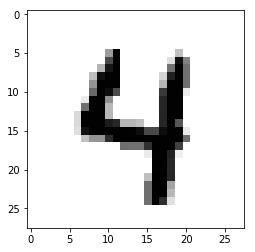

In [4]:
prediction = tf.argmax(y_conv,1)
i = randint(0, len(mnist.test.images))
image = mnist.test.images[i]
actual_label = mnist.test.labels[i]
predicted_label = sess.run(prediction, feed_dict={x: [image], keep_prob: 1.0})

print ("Image[%d] Predicted: %d, actual: %d" % (i, predicted_label, actual_label))
pylab.imshow(mnist.test.images[i].reshape((28,28)), cmap=pylab.cm.gray_r) 

In [5]:
# save model
export_dir = "/tmp/cnn/1"
!rm -fr /tmp/cnn/1
builder = saved_model_builder.SavedModelBuilder(export_dir)
classification_inputs = utils.build_tensor_info(serialized_tf_example)
classification_outputs_classes = utils.build_tensor_info(prediction_classes)
classification_outputs_scores = utils.build_tensor_info(values)

classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={ tf.saved_model.signature_constants.CLASSIFY_INPUTS:classification_inputs },
          outputs={ tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES: classification_outputs_classes,
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_SCORES: classification_outputs_scores
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

tensor_info_x = utils.build_tensor_info(x)
tensor_info_y = utils.build_tensor_info(y_conv)

prediction_signature = signature_def_utils.build_signature_def(
      inputs={'images': tensor_info_x, 'keep_prob': utils.build_tensor_info(keep_prob)},
      outputs={'scores': tensor_info_y},
      method_name=signature_constants.PREDICT_METHOD_NAME)

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={ 'predict_images': prediction_signature,
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: classification_signature,
      },
      legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/cnn/1/saved_model.pb


'/tmp/cnn/1/saved_model.pb'